# Single cell motility


### Model setup

The model definition file `Demo_CellMotility.xml` initializes a 2D hexagonal lattice of `Lx=200` and `Ly=200` with a single cell of target volume `200` $nodelength^2$ at starting position `x=100`, `y=100` and initial orientation (defined by PropertyVector dir) along the x-axis (`dir.phi=0`). 
From `t=0...500` with `dt=1` per Monte Carlo lattice update of the CPM, this cell performs a persistent random walk imposed by the DirectedMotion plugin with parameters Global/motion_strength and PropertyVector dir. The angle of dir is changed every dt=1 by a normally distributed random variable with `mean = 0` and `standard deviation` given by the parameter Global/noise_level.
For analysis purposes, a MotilityReporter calculates finite differences (`dt=1`) of cell center coordinates along the evolving trajectory and provides a PropertyVector velocity.
The Logger Plugin writes a text file with columns `time`,`cell.id`,`cell.center.x`,`cell.center.y`,`velocity.x`,`velocity.y`,`velocity.abs` and one row only every `100` time steps to emulate the coarser time resolution of image acquisition workflows.
On a single CPU core this model costs approximately 0.1sec total wall clock time (plots being disabled).
The two parameters Global/motion_strength and Global/noise_level control the statistics of the cell's persistent random walk.

*Ground truth data*
For the parameter choice `Global/motion_strength=1.0` and `Global/noise_level=0.1`, `N=100` repetitions for different random number sequences have been simulated and mean square displacement (MSD) and direction autocorrelation functions (DAC) have been computed from the 100fold coarser time sampling of the simulated cell trajectories. 
Note, these summary statistics are not (yet) computed within Morpheus but post-hoc in Python and manually entered as np.array measured_data. 
For plots of these data, see the bottom of the Python notebook.

### Parameter recovery study
Using FitMultiCell and adapting the workflow from MinimalExample.ipynb, the parameters are recovered from uniform priors over both parameter intervals from `0.1` to `10` fold the true values. There is some sign of parameter correlations stemming from the effective diffusion coefficient in the MSD statistics such that more random trajectories need a higher speed.
To obtain MSD and DAC summary statistics, an own distance measure is computed by the FFT algorithm from the tidynamics module for each single cell trajectory (`N=1` and not an ensemble of `N=100` as for the ground truth data) with sliding time windows over the `5` temporal data points (`tau=0,100,200,300,400` over pairs of data from the trajectory sampled at `t=0,100,200,300,400,500` after discarding a burn-in interval of the CPM cell shape initialisation till `t=100`, hence the data table arguments [1:] in the Python notebook).
The meta parameters are set to population_size=20 and 7 epochs.

### Details of summary statistics
```python
def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][1:],val1['IdSumstat__cell.center.y'][1:]]))\
                      - val2['IdSumstat__MSD']))
    return d
def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][1:]/val1['IdSumstat__velocity.abs'][1:],val1['IdSumstat__velocity.y'][1:]/val1['IdSumstat__velocity.abs'][1:]]))\
                      - val2['IdSumstat__DAC']))
    return d
distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])
```

In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import tidynamics                     # to get sliding history stats in N*logN instead of N^2

ABC.External ERROR: Install rpy2 to enable simple support for the R language.


In [2]:
file_ = str((Path(os.getcwd())) / 'models' / 'Demo_CellMotility.xml')
par_map = {'motion_strength': './Global/Constant[@symbol="motion_strength"]',
           'noise_level': './Global/Constant[@symbol="noise_level"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/usr/local/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)


In [3]:
true_pars = {'motion_strength': 1.0, 'noise_level': 0.1}
limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}

# generate ground truth data for recovery study
# simulated_data = model.sample(true_pars)

# experimentally measured data can be entered manually in this format
# the coarse time resolution of 100 times the simulation step size emulates observability limitations of experiments
measured_data = {'IdSumstat__time': np.array([0, 100, 200, 300, 400]),\
                 'IdSumstat__MSD': np.array([0, 1640, 5330, 10400, 15800]),\
                 'IdSumstat__DAC': np.array([1, 0.49, 0.19, 0.07, 0.07])}

In [4]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

# manually defined summary statistics

def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][1:],val1['IdSumstat__cell.center.y'][1:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][1:]/val1['IdSumstat__velocity.abs'][1:],val1['IdSumstat__velocity.y'][1:]/val1['IdSumstat__velocity.abs'][1:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

In [5]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=20)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test1.db")
history = abc.new(db_path, measured_data)

ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2021-09-29 15:50:49>


In [6]:
abc.run(max_nr_populations=7)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.31597117e+04.
ABC INFO: Accepted: 20 / 31 = 6.4516e-01, ESS: 2.0000e+01.
ABC INFO: t: 1, eps: 3.31597117e+04.
ABC INFO: Accepted: 20 / 31 = 6.4516e-01, ESS: 7.2446e+00.
ABC INFO: t: 2, eps: 3.31584789e+04.
ABC INFO: Accepted: 20 / 31 = 6.4516e-01, ESS: 1.7896e+01.
ABC INFO: t: 3, eps: 3.31431953e+04.
ABC INFO: Accepted: 20 / 31 = 6.4516e-01, ESS: 1.4740e+01.
ABC INFO: t: 4, eps: 3.31431953e+04.
ABC INFO: Accepted: 20 / 97 = 2.0619e-01, ESS: 1.0316e+01.
ABC INFO: t: 5, eps: 3.31333068e+04.
ABC INFO: Accepted: 20 / 31 = 6.4516e-01, ESS: 1.0938e+01.
ABC INFO: t: 6, eps: 3.31333068e+04.
ABC INFO: Accepted: 20 / 31 = 6.4516e-01, ESS: 1.7942e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=1, duration=0:00:08.110711, end_time=2021-09-29 15:50:58>


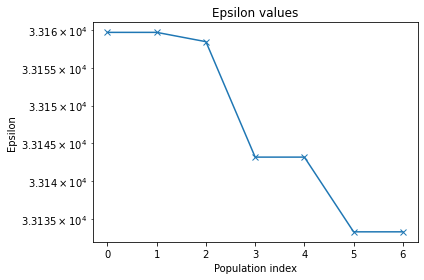

In [7]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

In [8]:
# summary statistics for N repetitions of the model simulation and plotting

fit_pars = {'motion_strength': 1.0, 'noise_level': 0.1}
N = 100 # runs to average over, make sure random_seed is off in Morpheus
time = np.arange(5)
meantival1 = np.zeros(5)
meantival2 = np.zeros(5)
semtival1 = np.zeros(5)
semtival2 = np.zeros(5)
count = 0

for i in range(N):
    simulated_data = model.sample(fit_pars)
    val1vec = np.column_stack([simulated_data['IdSumstat__cell.center.x'][1:],simulated_data['IdSumstat__cell.center.y'][1:]])
    meantival1 += tidynamics.msd(val1vec)
    semtival1 += (tidynamics.msd(val1vec))**2
    val2vec = np.column_stack([simulated_data['IdSumstat__velocity.x'][1:]/simulated_data['IdSumstat__velocity.abs'][1:],simulated_data['IdSumstat__velocity.y'][1:]/simulated_data['IdSumstat__velocity.abs'][1:]])
    meantival2 += tidynamics.acf(val2vec)    
    semtival2 += (tidynamics.acf(val2vec))**2
    count += 1

meantival1 /= count
semtival1 = np.sqrt(((semtival1 / count) - (meantival1)**2) / count)
meantival2 /= count
semtival2 = np.sqrt(((semtival2 / count) - (meantival2)**2) / count)

print('mean MSD = ',meantival1)
print( 'sem MSD = ',semtival1)
print('mean DAC = ',meantival2)
print( 'sem DAC = ',semtival2)

# plot MSD
plt.plot(measured_data['IdSumstat__time'], meantival1, label='Simulation mean')
plt.legend()
plt.title('mean square displacement')
plt.xlabel(r'$\tau$')
plt.ylabel(r'mean square displacement')
plt.show()

# plot DAC
plt.plot(measured_data['IdSumstat__time'], meantival2, label='Simulation')
plt.legend()
plt.title('direction autocorrelation')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\langle v(t) v(t+\tau) \rangle$')
plt.show()

mean MSD =  [2.03726813e-12 1.89091802e+00 3.12079854e+00 4.79236134e+00
 7.19687105e+00]
sem MSD =  [3.16830987e-12 9.55754127e-02 1.63464625e-01 4.05860448e-01
 6.24259699e-01]
mean DAC =  [ 1.          0.17727642 -0.11698352 -0.08924638  0.14890044]
sem DAC =  [       nan 0.02966805 0.03848234 0.05968665 0.06485648]


/home/emad/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt
